# RCCA vs Baseline Comparison

This notebook compares the original **Mask-Centering Bootstrapping** algorithm with the new **Region-Constrained Cross-Attention Isolation (RCCA)**.

We compare:
1. **Inference Speed (FPS)**: Should be similar or better with RCCA.
2. **Visual Quality**: RCCA should reduce "Center Bias" and background artifacts.

In [8]:
import sys
import time
import warnings
import gc

sys.path.append('../src')
warnings.filterwarnings('ignore')

import torch
import torchvision.transforms as T
from PIL import Image
from diffusers.utils import make_image_grid
from IPython.display import clear_output, display

from util import seed_everything, get_torch_device, empty_cache
# Import both versions
from model.semantic_draw_original import SemanticDraw as SemanticDrawOriginal
from model.semantic_draw import SemanticDraw as SemanticDrawRCCA

device = get_torch_device()
seed = 2024
seed_everything(seed)
print(f'[INFO] Initialized with seed  : {seed}')
print(f'[INFO] Initialized with device: {device}')

[INFO] Initialized with seed  : 2024
[INFO] Initialized with device: mps


[INFO] Loading masks...


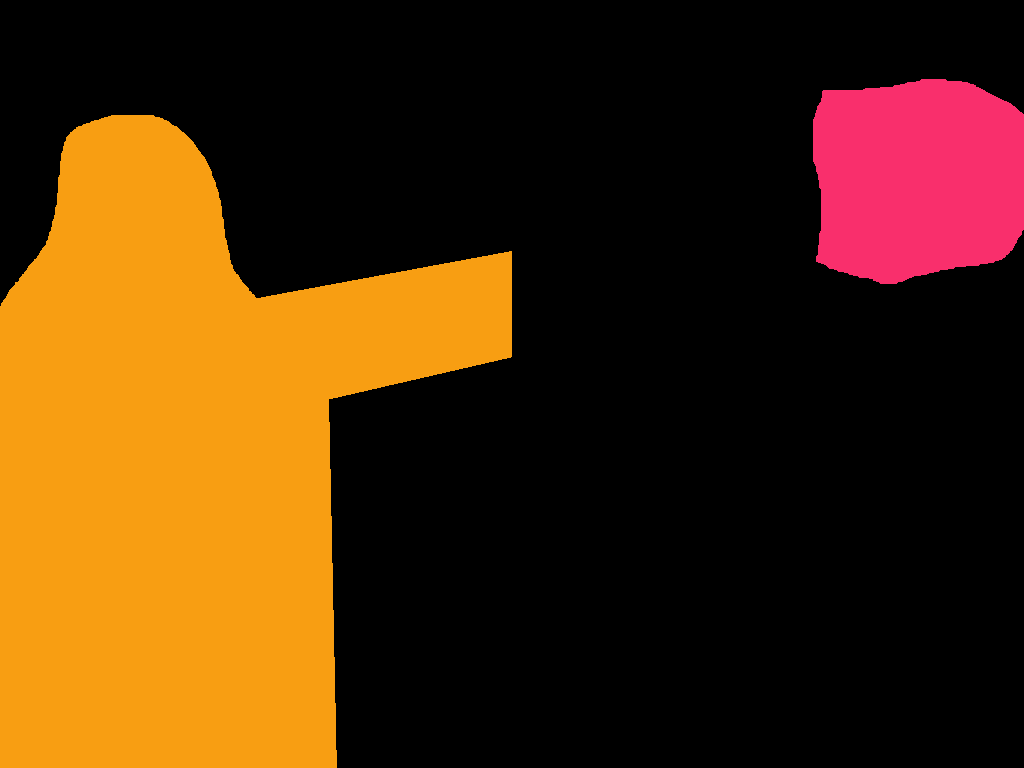

In [9]:
# Load Masks (same as demo)
print('[INFO] Loading masks...') 
mask_p1 = Image.open('../assets/zeus/prompt_p1.png').convert('RGBA')
mask_p2 = Image.open('../assets/zeus/prompt_p2.png').convert('RGBA')

mask_p1_t = T.ToTensor()(mask_p1)[-1:]
mask_p2_t = T.ToTensor()(mask_p2)[-1:]
background_t = torch.logical_and(mask_p1_t == 0, mask_p2_t == 0)

height, width = mask_p1_t.shape[-2:]
display(make_image_grid([mask_p1, mask_p2], 1, 2))

In [10]:
def run_benchmark(ModelClass, title):
    print(f"\n--- Running {title} ---")
    seed_everything(seed)
    
    # Initialize Model
    streamer = ModelClass(
        device,
        height=height,
        width=width,
        cfg_type="none",
        autoflush=True,
        use_tiny_vae=False,
        mask_type='continuous',
        bootstrap_steps=2, # Relevant for Original, Ignored/Deprecated for RCCA
        seed=seed,
    )
    
    # Register Background & Layers
    streamer.update_background(Image.new(size=(width, height), mode='RGB', color=(255, 255, 255)))
    
    streamer.update_single_layer(0, 'a photo of Mount Olympus', '', background_t, 1.0, 0.0, 1.0)
    streamer.update_single_layer(1, 'Greek god Zeus looking at viewer', '', mask_p1_t, 1.0, 0.0, 1.0)
    streamer.update_single_layer(2, 'a small, sitting eagle', '', mask_p2_t, 1.0, 0.0, 1.0)
    
    # Warmup
    print("Warming up...")
    for _ in range(3):
        streamer()
        
    # Benchmark Loop
    print("Benchmarking...")
    t0 = time.time()
    n_frames = 30
    for _ in range(n_frames):
        img = streamer()
    t1 = time.time()
    
    fps = n_frames / (t1 - t0)
    print(f"{title} Results:")
    print(f"  FPS: {fps:.2f}")
    
    # cleanup to save VRAM
    del streamer
    empty_cache()
    gc.collect()
    
    return img, fps

In [11]:
# Run Original
img_orig, fps_orig = run_benchmark(SemanticDrawOriginal, "Original (Mask Centering)")


--- Running Original (Mask Centering) ---
[INFO]     Loading Stable Diffusion...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

ValueError: PEFT backend is required for this method.

In [ ]:
# Run RCCA
img_rcca, fps_rcca = run_benchmark(SemanticDrawRCCA, "RCCA (Attention Masking)")

## Comparison Results

In [ ]:
print(f"Original FPS: {fps_orig:.2f}")
print(f"RCCA FPS    : {fps_rcca:.2f}")
print(f"Speedup     : {fps_rcca/fps_orig:.2f}x")

print("Left: Original, Right: RCCA")
display(make_image_grid([img_orig, img_rcca], 1, 2))